In [1]:
import argparse
import sys
import matplotlib 
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import gym
import envs
import pickle
#import gridworld_env
from gym import wrappers, logger
import numpy as np
import copy

Etant donné, que les données retournées par envx.getMDP() sont peu lisibles et moins facile a manipuler, on se propose de re-structurer des données. De sorte d'avoir un dictionnaire organiser de la façon suivante:
proba = {state's num : action's num : {next_state: proba}*}
rewards = {state's num : action's num : {next_state: reward}*}

In [2]:
#transformation
def transform(envx, norm=True):
    """return proba sous le format decrit plus haut et rewards
    """
    
    #version 1
    """    proba = {}
    for state_name, rest in envx.getMDP()[1].items():     
            actions = {}
            for action in rest.keys():
                transitions = {}   
                for p in rest[action]:
                    transitions[envx.getMDP()[0][p[1]]] = p[0]
                actions[action] = transitions
            proba[envx.getMDP()[0][state_name]] = actions
    """
    #version 2
    proba = { envx.getMDP()[0][state_name]: 
    { 
        action : 
        {
            envx.getMDP()[0][p[1]] :  
            p[0]  for p in rest[action] 
        } 
        for action in rest.keys()
    }
    for state_name, rest in envx.getMDP()[1].items()
   }
    #normalisation des probas
    if norm:
        #version 1
        for s in proba:
            for a in proba[s]:
                tmp = np.sum(list(proba[s][a].values()))
                for k, v in proba[s][a].items():
                    proba[s][a][k] = v/tmp         
        #vesrion 2
        #proba = {state: {a: {proba[state][a][s]: j/np.sum(list(proba[state][a].values())) 
        #     for s, j in proba[state][a].items()}for a in proba[state]}for state, v in proba.items()}
        #version 2               
    rewards = { envx.getMDP()[0][state_name]: 
    { 
        action : 
        {
            envx.getMDP()[0][p[1]] :  
            p[2]  for p in rest[action] 
        } 
        for action in rest.keys()
    }
    for state_name, rest in envx.getMDP()[1].items()
   }
    return proba, rewards

In [3]:
class ValueIteration(object):
    
    def __init__(self, envx, plan, discount=1, eps=.0001, robot=2):
        self.eps = eps
        self.envx = envx
        self.robot = robot 
        self.plan = plan
        self.discount = discount
        self.action_space = envx.action_space 
        self.proba, self.rewards = transform(envx)
        #self.values : dict mieux que array car ils manquent certains etats
        self.values =  {state : 0 for state in envx.getMDP()[0].values()}
        # <!> les observations sont dans un fichier binaires,  sér
        self.observation_to_state = {str(pickle.loads(list(envx.getMDP()[0].keys())[state])): 
                        state  for state in envx.getMDP()[0].values()} 
        
    def get_action_value(self, current_state, action):
        #version 1
        #t = np.sum([prob*(self.rewards[current_state][action][next_state] + self.discount*self.values[next_state]) for next_state, prob in self.proba[current_state][action].items()])
        #return t
        q = 0
        for next_state, prob in self.proba[current_state][action].items():
            q += prob*(self.rewards[current_state][action][next_state]+self.discount*self.values[next_state])              
        return q

    def get_new_state_value(self, current_state):
        values = [self.get_action_value(current_state, action) for action in self.proba[current_state]]
        action =  np.argmax(values)
        value = values[int(action)]
        return action, value
    
    def check_policy(self, state):
        if state not in self.policy_dico.keys():
            #ce cas n'est pas arrivé
            self.policy_dico[state] = None
        return self.policy_dico[state]
    
    def fit(self):
        delta = np.inf
        
        while delta > self.eps:
            delta = 0
            for state in self.proba:
                v_old = self.values[state]
                new_action, new_value = self.get_new_state_value(state)
                self.values[state] = new_value
                delta = max(delta, abs(v_old - self.values[state]))      
        self.policy_dico = {state:  self.get_new_state_value(state)[0] for state in self.proba }
        
    def plt_values(self):
        grid_size = pickle.loads(list(self.envx.getMDP()[0].keys())[5]).shape
        self.grid = np.zeros(grid_size)
        
        for state_name, state_num in self.envx.getMDP()[0].items():
            state_serial = np.array(pickle.loads(state_name))
            x, y  = np.where(state_serial == self.robot)
            self.grid[x, y] = self.values[state_num]
        print(self.values)
        plt.title(str(self.plan))
        plt.imshow(self.grid, cmap ='gray')
        plt.show()
        

    def act(self, observation, reward, done):
        return self.check_policy(self.observation_to_state[str(observation)])

In [14]:
def main(plan):
    outdir = 'gridworld-v0/random-agent-results'
    envx = gym.make('gridworld-v0')
    env = wrappers.Monitor(envx, directory=outdir, force=True, video_callable=False)
    env.seed(0)
    episode_count = 1000
    reward = 0
    done = False
    envx.verbose = True
    envx.setPlan("gridworldPlans/plan0.txt", plan )

    agent = ValueIteration(envx, plan)
    #np.random.seed(5)
    agent.fit()
    rsum=0

    for i in range(episode_count):
        ob = env.reset()

        if i % 100 == 0 and i > 0:
            envx.verbose = True
        else:
            envx.verbose = False

        if envx.verbose:
                #envx.render(1)
                1
        j = 0
        #print(str(ob))
        while True:

            action = agent.act(ob, reward, done)
            ob, reward, done, _ = env.step(action)
            rsum+=reward
            j += 1
            if envx.verbose:
                #envx.render()
                1
            if done:
                #print(str(i)+" rsum="+str(rsum)+", "+str(j)+" actions")
                rsum=0
                break

    print("done")
    env.close()
    return agent, envx
    #agent.plt_values()

['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
done
{0: 89.09356278711778, 1: 0, 2: 91.09362451760431, 3: 89.87272094447603, 4: 98.65252345091896, 5: 0, 6: 97.52752218387678, 7: 96.13689430221427, 8: 95.0118929302052, 9: 93.62126480981411, 10: 92.49626332414226}


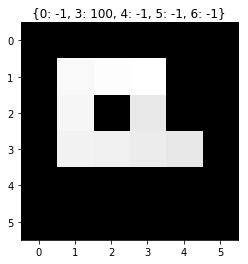

In [15]:
#1.1
plan =  {0: -1, 3: 100 , 4: -1, 5: -1, 6: -1}
agent, envx = main(plan)
agent.plt_values()

In [60]:
p =  {state : 0 for state in envx.getMDP()[0].values()}
print(p)
unique = np.unique([list(actions.keys()) for actions in envx.getMDP()[1].values()])
#p =  {state : 0 for state in unique}
unique

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}


array([0, 1, 2, 3])

In [80]:
actions_possibles = set([v for actions in envx.getMDP()[1].values() for v in list(actions.keys())])
p = {state : random.choice(list(actions_possibles)) for state in range(len(envx.getMDP()[0].values()))}

In [81]:
p

{0: 0, 1: 2, 2: 3, 3: 2, 4: 2, 5: 0, 6: 0, 7: 1, 8: 3, 9: 3, 10: 1}

In [77]:
[random.choice(list(actions_possibles)) for _ in range(len(envx.getMDP()[0]))]

[2, 2, 2, 0, 0, 0, 1, 1, 0, 3, 2]

{0: 0.9997934902998437, 1: 0, 2: 0.9998615836071928, 3: 0.9995137425791893, 4: 0.9999447597067985, 5: 0, 6: 0.9999433620652634, 7: 0.9999401833776884, 8: 0.9999386699498807, 9: 0.9999352279269822, 10: 0.9999335891206993}


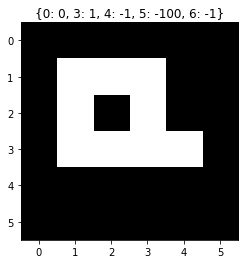

In [40]:
#1.1
plan =  {0: 2, 3: 100 , 4: -1, 5: -1, 6: -1}
#agent = main(plan)
agent.plt_values()

{0: 0.9997934902998437, 1: 0, 2: 0.9998615836071928, 3: 0.9995137425791893, 4: 0.9999447597067985, 5: 0, 6: 0.9999433620652634, 7: 0.9999401833776884, 8: 0.9999386699498807, 9: 0.9999352279269822, 10: 0.9999335891206993}


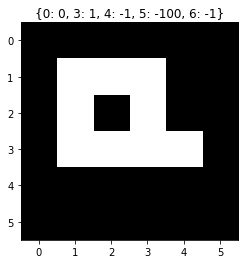

In [35]:
#1.1
plan =  {0: 1, 3: 2 , 4: -1, 5: -100, 6: -1}
#agent = main(plan)
agent.plt_values()

['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
done
{0: 0.9997934902998437, 1: 0, 2: 0.9998615836071928, 3: 0.9995137425791893, 4: 0.9999447597067985, 5: 0, 6: 0.9999433620652634, 7: 0.9999401833776884, 8: 0.9999386699498807, 9: 0.9999352279269822, 10: 0.9999335891206993}


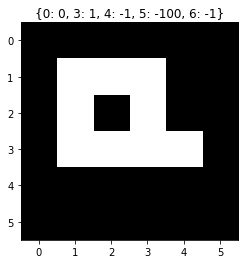

In [32]:
#1.2
plan =  {0: 0, 3: 1 , 4: -1, 5: -100, 6: -1}
agent = main(plan)
agent.plt_values()

['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
done
{0: -2.163652155580923, 1: 0, 2: -5.4728785353134555, 3: -1.9466955712047138, 4: 0.005922725206160551, 5: 0, 6: -3.369077254826464, 7: -7.540932845615481, 8: -10.9159218417128, 9: -12.410978584670309, 10: -8.847877433942058}


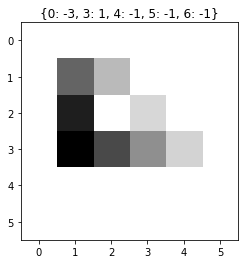

In [16]:
#2.1
plan =  {0: -3, 3: 1 , 4: -1, 5: -1, 6: -1}
agent = main(plan)
agent.plt_values()

['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
done
{0: -3.571426958255077, 1: 0, 2: 0.6071672453321454, 3: 5.301369781507981, 4: 10.589041081832756, 5: 0, 6: 7.214041072451179, 7: 3.042165787301826, 8: -0.33283437217929185, 9: -3.9367271934794266, 10: -2.767835421105878}


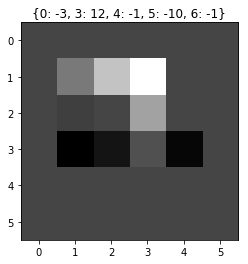

In [15]:
#2.3
plan =  {0: -3, 3: 12 , 4: -1, 5: -10, 6: -1}
agent = main(plan)
agent.plt_values()

['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
done
{0: -23.274235157138513, 1: 0, 2: -17.27429851570548, 3: -12.808219178082066, 4: 1.465753424657556, 5: 0, 6: -1.9092465753424293, 7: -6.081121575341355, 8: -9.456121575340749, 9: -13.627996575327801, 10: -17.002996575320598}


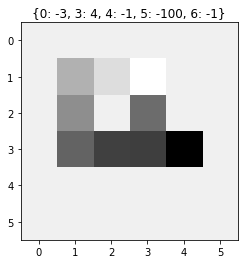

In [14]:
#2.2
plan =  {0: -3, 3: 4 , 4: -1, 5: -100, 6: -1}
agent = main(plan)
agent.plt_values()

['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
done
{0: 18.92735880699737, 1: 0, 2: 24.92742994844899, 3: 29.849315068492977, 4: 38.20547945205477, 5: 0, 6: 34.830479452054746, 7: 30.658604452052835, 8: 27.283604452051755, 9: 23.313472650876903, 10: 21.552428857460576}


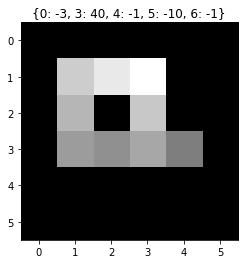

In [10]:
plan =  {0: -3, 3: 40 , 4: -1, 5: -10, 6: -1}
agent = main(plan)
agent.plt_values()